In [ ]:
import os
import numpy as np
import pickle
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap
import flax.linen as nn
from flax.training import train_state
import optax
from tensorflow_datasets import load as tfds_load
from tqdm import tqdm
from matplotlib import pyplot as plt

In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 729.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.5 MB/s eta 0:00:00


In [ ]:
# Config model
T = 300  # Max diffusion step
max_seq_length = 5
vocab_size = 27  # ' ': 0, 'a':1, ..., 'z':26
hidden_dim = 256

batch_size = 32
rng = random.PRNGKey(0)

In [ ]:
# Download dataset
import tensorflow_datasets as tfds

def preprocess(sample):
    image = sample['image']
    label = sample['label']
    # Convert to float32 and normalize to [0, 1]
    image = jnp.array(image, dtype=jnp.float32) / 255.0
    # Add channel dimension
    image = jnp.expand_dims(image, axis=-1)
    return image, label

# Load MNIST dataset
ds = tfds.load('mnist', split='train', as_supervised=False, shuffle_files=True)
ds = ds.shuffle(1024).batch(batch_size).prefetch(1)

# Convert to numpy iterator
def create_data_iterator(dataset):
    for batch in dataset:
        images = jnp.array(batch['image'], dtype=jnp.float32) / 255.0
        images = jnp.transpose(images, (0, 3, 1, 2))  # NHWC to NCHW
        labels = jnp.array(batch['label'])
        yield images, labels

train_data_loader = ds

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.37IU1Y_3.0.1/mnist-train.tfrecord*...:   0%|          | 0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.37IU1Y_3.0.1/mnist-test.tfrecord*...:   0%|          | 0/…

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
# Utilities
n2t_mapping = {
    0: "zero",
    1: "one",
    2: "two",
    3: "three",
    4: "four",
    5: "five",
    6: "six",
    7: "seven",
    8: "eight",
    9: "nine",
    10: "ten",
}

string_to_token = lambda x: [ord(i) - 96 for i in x]  # ' ': 0, 'a':1, ..., 'z':26
# token_to_string = lambda x: [chr(i + 96) for i in x] # We do not need it here


def convert_text_label(number_labels):
    text_labels = jnp.zeros((len(number_labels), max_seq_length, vocab_size))
    labels_list = []
    for bidx, nlb in enumerate(number_labels):
        label_one_hot = jnp.zeros((max_seq_length, vocab_size))
        tokens = string_to_token(n2t_mapping[int(nlb)])
        for tidx, token in enumerate(tokens):
            label_one_hot = label_one_hot.at[tidx, token].set(1.0)
        labels_list.append(label_one_hot)
    return jnp.stack(labels_list)


def show_img(img):
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

In [ ]:
# Models for noise estimation using Flax
class ResidualConvBlock(nn.Module):
    in_channels: int
    out_channels: int
    is_res: bool = False
    training: bool = True

    @nn.compact
    def __call__(self, x, training=None):
        if training is None:
            training = self.training

        same_channels = self.in_channels == self.out_channels

        x1 = nn.Conv(self.out_channels, kernel_size=(3, 3), strides=1, padding=1)(x)
        x1 = nn.BatchNorm(use_running_average=not training)(x1)
        x1 = nn.gelu(x1)

        x2 = nn.Conv(self.out_channels, kernel_size=(3, 3), strides=1, padding=1)(x1)
        x2 = nn.BatchNorm(use_running_average=not training)(x2)
        x2 = nn.gelu(x2)

        if self.is_res:
            if same_channels:
                out = x + x2
            else:
                out = x1 + x2
            return out / 1.414
        else:
            return x2


class UnetDown(nn.Module):
    in_channels: int
    out_channels: int

    @nn.compact
    def __call__(self, x, training=True):
        x = ResidualConvBlock(self.in_channels, self.out_channels)(x, training=training)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
        return x


class UnetUp(nn.Module):
    in_channels: int
    out_channels: int

    @nn.compact
    def __call__(self, x, skip, training=True):
        # Concatenate first (before upsampling), then upsample
        # x and skip should have the same spatial dimensions
        x = jnp.concatenate([x, skip], axis=-1)

        # Transpose convolution for upsampling
        x = nn.ConvTranspose(self.out_channels, kernel_size=(2, 2), strides=(2, 2))(x)

        x = ResidualConvBlock(self.out_channels, self.out_channels)(x, training=training)
        x = ResidualConvBlock(self.out_channels, self.out_channels)(x, training=training)
        return x


class EmbedFC(nn.Module):
    input_dim: int
    emb_dim: int

    @nn.compact
    def __call__(self, x):
        x = x.reshape(-1, self.input_dim)
        x = nn.Dense(self.emb_dim)(x)
        x = nn.gelu(x)
        x = nn.Dense(self.emb_dim)(x)
        return x


class ContextUnet(nn.Module):
    in_channels: int
    n_feat: int = 256
    n_classes: int = 10

    @nn.compact
    def __call__(self, x, c, t, context_mask, training=True):
        # Convert from NCHW to NHWC for Flax
        x_orig = jnp.transpose(x, (0, 2, 3, 1))

        # Initial convolution
        x = ResidualConvBlock(self.in_channels, self.n_feat, is_res=True)(x_orig, training=training)

        # Downsample
        down1 = UnetDown(self.n_feat, self.n_feat)(x, training=training)  # (batch, 14, 14, 256)
        down2 = UnetDown(self.n_feat, 2 * self.n_feat)(down1, training=training)  # (batch, 7, 7, 512)

        # To vector - down2 shape is (batch, 7, 7, 512)
        hiddenvec = jnp.mean(down2, axis=(1, 2), keepdims=True)  # (batch, 1, 1, 512)
        hiddenvec = nn.gelu(hiddenvec)

        # Mask out context if context_mask == 1
        context_mask = -1 * (1 - context_mask)  # flip 0 <-> 1
        c = c * context_mask

        # Context embeddings using linear transformation (simplified from GRU)
        cemb1 = nn.Dense(2 * self.n_feat)(c.reshape(c.shape[0], -1))
        cemb1 = cemb1.reshape(-1, 1, 1, 2 * self.n_feat)  # (batch, 1, 1, 512)

        cemb2 = nn.Dense(1 * self.n_feat)(c.reshape(c.shape[0], -1))
        cemb2 = cemb2.reshape(-1, 1, 1, 1 * self.n_feat)  # (batch, 1, 1, 256)

        # Time embeddings
        temb1 = EmbedFC(1, 2 * self.n_feat)(t)
        temb1 = temb1.reshape(-1, 1, 1, 2 * self.n_feat)  # (batch, 1, 1, 512)

        temb2 = EmbedFC(1, 1 * self.n_feat)(t)
        temb2 = temb2.reshape(-1, 1, 1, 1 * self.n_feat)  # (batch, 1, 1, 256)

        # Upsample
        up1 = nn.ConvTranspose(2 * self.n_feat, kernel_size=(7, 7), strides=(7, 7))(hiddenvec)
        up1 = nn.GroupNorm(8)(up1)
        up1 = nn.relu(up1)  # (batch, 7, 7, 512)

        # Add and multiply embeddings
        up2_input = cemb1 * up1 + temb1  # (batch, 7, 7, 512)
        # Now up2_input and down2 have same spatial dims (7, 7), concat then upsample
        up2 = UnetUp(4 * self.n_feat, self.n_feat)(up2_input, down2, training=training)  # (batch, 14, 14, 256)

        esp_theta_w_context_input = cemb2 * up2 + temb2  # (batch, 14, 14, 256)
        # Now both have spatial dims (14, 14), concat then upsample
        esp_theta_w_context = UnetUp(2 * self.n_feat, self.n_feat)(esp_theta_w_context_input, down1, training=training)  # (batch, 28, 28, 256)

        # Without context path - x is already in NHWC format (batch, 28, 28, 256)
        # Add time embedding (need to broadcast t properly)
        t_broadcast = t[:, None, None, :]  # (batch, 1, 1, 1)
        esp_theta_wo_context = x + t_broadcast  # (batch, 28, 28, 256)

        # Final output
        out = jnp.concatenate([esp_theta_w_context, esp_theta_wo_context], axis=-1)  # (batch, 28, 28, 512)
        out = nn.Conv(self.n_feat, kernel_size=(3, 3), strides=1, padding=1)(out)
        out = nn.GroupNorm(8)(out)
        out = nn.relu(out)
        out = nn.Conv(self.in_channels, kernel_size=(3, 3), strides=1, padding=1)(out)

        # Convert back to NCHW format for output
        out = jnp.transpose(out, (0, 3, 1, 2))

        return out

In [ ]:
# Initialize model
model = ContextUnet(in_channels=1, n_feat=hidden_dim, n_classes=vocab_size)

# Create a sample input for initialization
rng, init_rng = random.split(rng)
sample_x = jnp.ones((1, 1, 28, 28))
sample_c = jnp.ones((1, max_seq_length, vocab_size))
sample_t = jnp.ones((1, 1))
sample_mask = jnp.zeros((1, max_seq_length, vocab_size))

variables = model.init(init_rng, sample_x, sample_c, sample_t, sample_mask, training=True)

# Create optimizer
learning_rate = 1e-4
tx = optax.adam(learning_rate)

# Create training state - include batch_stats
class TrainState(train_state.TrainState):
    batch_stats: dict

state = TrainState.create(
    apply_fn=model.apply,
    params=variables['params'],
    tx=tx,
    batch_stats=variables['batch_stats'],
)

In [ ]:
# Load saved models
# import pickle
# with open('contextual_model_params.pkl', 'rb') as f:
#     loaded_params = pickle.load(f)
# state = state.replace(params=loaded_params)
#
# with open('beta_t.pkl', 'rb') as f:
#     beta_t = pickle.load(f)

In [ ]:
# Setting hyperparameters for diffusion process
beta_1 = 1e-4
beta_2 = 2e-2
beta_t = (beta_2 - beta_1) * jnp.arange(0, T + 1, dtype=jnp.float32) / T + beta_1

alpha_t = 1 - beta_t
alphabar_t = jnp.exp(jnp.cumsum(jnp.log(alpha_t), axis=0))

sqrtab = jnp.sqrt(alphabar_t)
sqrtmab = jnp.sqrt(1 - alphabar_t)

sqrt_beta_t = jnp.sqrt(beta_t)
oneover_sqrta = 1 / jnp.sqrt(alpha_t)
mab_over_sqrtmab = (1 - alpha_t) / sqrtmab

In [ ]:
# TRAINING
@jit
def train_step(state, x_in, context, t, esp, context_mask, t_norm):
    def loss_fn(params):
        # Forward pass with batch_stats
        x_t = sqrtab[t, None, None, None] * x_in + sqrtmab[t, None, None, None] * esp
        variables = {'params': params, 'batch_stats': state.batch_stats}
        esp_theta, new_model_state = state.apply_fn(
            variables, x_t, context, t_norm, context_mask,
            training=True,
            mutable=['batch_stats']
        )

        # MSE loss
        loss = jnp.mean((esp - esp_theta) ** 2)
        return loss, new_model_state

    (loss, new_model_state), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    state = state.replace(batch_stats=new_model_state['batch_stats'])
    return state, loss

EPOCHS = 1

for e in range(EPOCHS):
    print(f"========== EPOCH {e} ==========")
    total_loss = 0
    batch_idx = 0

    for batch in tqdm(train_data_loader, desc=f"Epoch {e + 1}"):
        # Input preparation
        images = jnp.array(batch['image'], dtype=jnp.float32) / 255.0
        x_in = jnp.transpose(images, (0, 3, 1, 2))  # NHWC to NCHW
        labels = jnp.array(batch['label'])

        context = convert_text_label(labels)

        # Forward diffusion
        rng, t_rng, esp_rng, mask_rng = random.split(rng, 4)

        # Sample random timesteps
        t = random.randint(t_rng, (x_in.shape[0],), 1, T)

        # Sample noise
        esp = random.normal(esp_rng, x_in.shape)

        # Sample context mask
        context_mask = random.bernoulli(mask_rng, 0.1, context.shape)

        # Normalize timesteps
        t_norm = (t / T).astype(jnp.float32)
        t_norm = t_norm[:, None]  # Add dimension for embedding

        # Training step
        state, loss = train_step(state, x_in, context, t, esp, context_mask, t_norm)

        total_loss += float(loss)
        if batch_idx % 100 == 0:
            print(f"\tLoss: {loss:.4f}")

        batch_idx += 1

    print(f"Average Loss: {total_loss / batch_idx:.4f}")

========== EPOCH 0 ==========


Epoch 1:   0%|          | 1/1875 [01:07<35:00:15, 67.24s/it]

	Loss: 1.2459


Epoch 1:   5%|▌         | 102/1875 [01:25<05:00,  5.89it/s]

	Loss: 0.1203


Epoch 1:  11%|█         | 202/1875 [01:43<05:19,  5.23it/s]

	Loss: 0.0745


Epoch 1:  16%|█▌        | 302/1875 [02:00<04:28,  5.86it/s]

	Loss: 0.0463


Epoch 1:  21%|██▏       | 401/1875 [02:17<04:37,  5.31it/s]

	Loss: 0.0540


Epoch 1:  27%|██▋       | 502/1875 [02:34<03:40,  6.23it/s]

	Loss: 0.0837


Epoch 1:  32%|███▏      | 602/1875 [02:52<03:34,  5.93it/s]

	Loss: 0.0708


Epoch 1:  37%|███▋      | 702/1875 [03:09<03:42,  5.26it/s]

	Loss: 0.0482


Epoch 1:  43%|████▎     | 802/1875 [03:26<02:55,  6.12it/s]

	Loss: 0.0506


Epoch 1:  48%|████▊     | 902/1875 [03:44<02:40,  6.07it/s]

	Loss: 0.0418


Epoch 1:  53%|█████▎    | 1001/1875 [04:01<02:59,  4.86it/s]

	Loss: 0.0512


Epoch 1:  59%|█████▉    | 1102/1875 [04:19<02:22,  5.42it/s]

	Loss: 0.0359


Epoch 1:  64%|██████▍   | 1202/1875 [04:37<01:50,  6.07it/s]

	Loss: 0.0335


Epoch 1:  69%|██████▉   | 1302/1875 [04:54<01:43,  5.55it/s]

	Loss: 0.0346


Epoch 1:  75%|███████▍  | 1401/1875 [05:11<01:30,  5.26it/s]

	Loss: 0.0450


Epoch 1:  80%|████████  | 1502/1875 [05:29<01:13,  5.07it/s]

	Loss: 0.0488


Epoch 1:  85%|████████▌ | 1602/1875 [05:46<00:49,  5.47it/s]

	Loss: 0.0475


Epoch 1:  91%|█████████ | 1702/1875 [06:04<00:33,  5.18it/s]

	Loss: 0.0348


Epoch 1:  96%|█████████▌| 1802/1875 [06:22<00:12,  5.91it/s]

	Loss: 0.0605


Epoch 1: 100%|██████████| 1875/1875 [06:34<00:00,  4.75it/s]

Average Loss: 0.0596


In [ ]:
# Save models
with open('contextual_model_params.pkl', 'wb') as f:
    pickle.dump(state.params, f)
with open('beta_t.pkl', 'wb') as f:
    pickle.dump(np.array(beta_t), f)

In [ ]:
# SAMPLING
def sampling_imgs(state, list_numbers, return_steps=[], mode="ddpm", rng_key=None):
    if rng_key is None:
        rng_key = random.PRNGKey(42)

    rng_key, noise_rng = random.split(rng_key)
    x_T = random.normal(noise_rng, (len(list_numbers), 1, 28, 28))

    context = convert_text_label(jnp.array(list_numbers))
    context_mask = jnp.zeros_like(context)

    x_t = x_T
    if len(return_steps) > 0:
        reverse_steps = []

    # Reverse diffusion
    for t in tqdm(range(T, 0, -1)):
        if t in return_steps:
            reverse_steps.append(np.array(x_t))

        norm_t = jnp.array([t / T]).repeat(len(list_numbers))
        norm_t = norm_t[:, None]

        # Use batch_stats in inference mode (training=False)
        variables = {'params': state.params, 'batch_stats': state.batch_stats}
        esp_theta = state.apply_fn(variables, x_t, context, norm_t, context_mask, training=False)

        if mode == "ddpm":  # Probabilistic
            sigma = (
                jnp.sqrt((1 - alphabar_t[t - 1]) / (1 - alphabar_t[t]))
                * sqrt_beta_t[t]
            )

            if t > 1:
                rng_key, z_rng = random.split(rng_key)
                z = random.normal(z_rng, (len(list_numbers), 1, 28, 28))
            else:
                z = 0

            x_t = (
                oneover_sqrta[t] * (x_t - esp_theta * mab_over_sqrtmab[t]) + sigma * z
            )

        elif mode == "ddim":  # Deterministic
            sigma = 1e-3

            if t > 1:
                rng_key, z_rng = random.split(rng_key)
                z = random.normal(z_rng, (len(list_numbers), 1, 28, 28))
            else:
                z = 0

            x_t = (
                oneover_sqrta[t] * (x_t - esp_theta * sqrtmab[t])
                + esp_theta * jnp.sqrt(1 - alphabar_t[t - 1] - sigma**2)
                + sigma * z
            )

    if len(return_steps) > 0:
        reverse_steps.append(np.array(x_t))
        return reverse_steps

    return np.array(x_t)

100%|██████████| 300/300 [00:55<00:00,  5.44it/s]


Number 'zero'


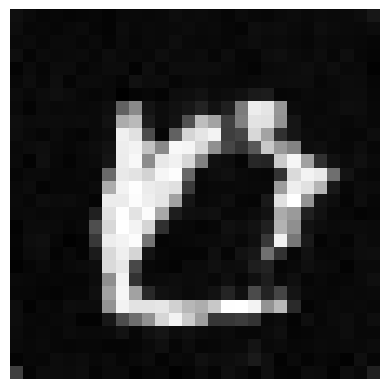

Number 'one'


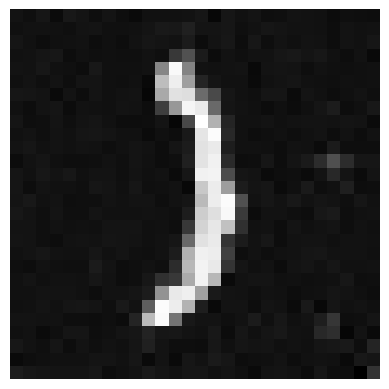

Number 'two'


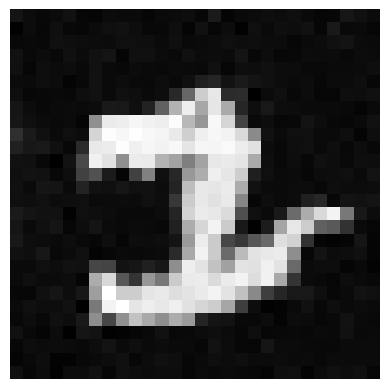

Number 'three'


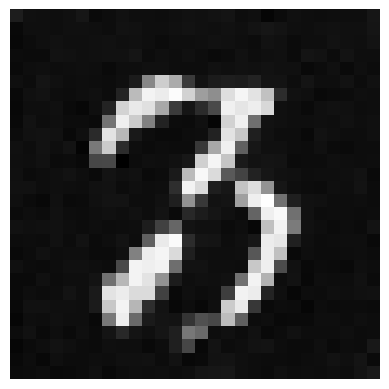

Number 'four'


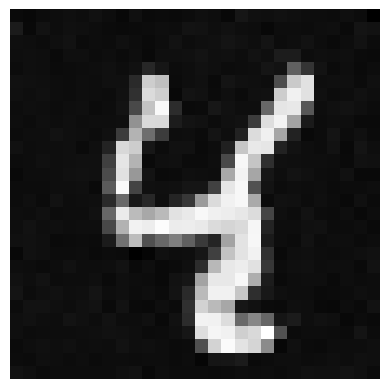

Number 'five'


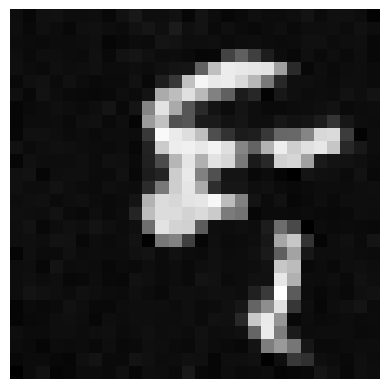

Number 'six'


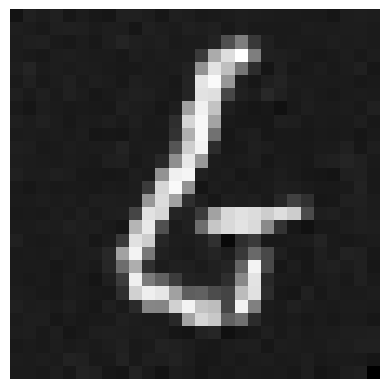

Number 'seven'


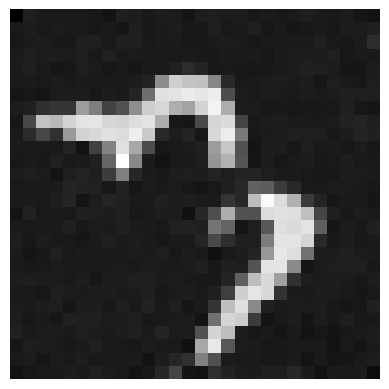

Number 'eight'


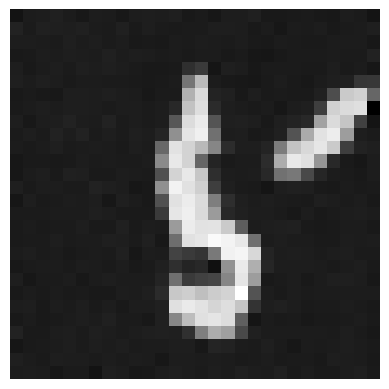

Number 'nine'


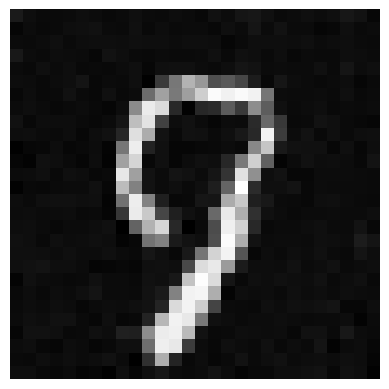

Number 'ten'


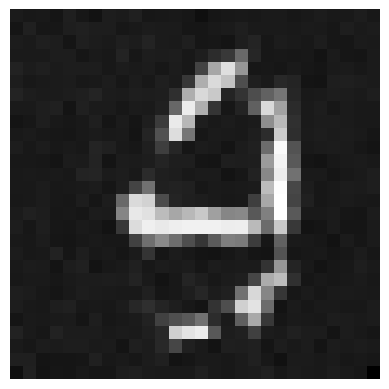

In [ ]:
# Run testing DDIM
test_numbers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
sampled_imgs = sampling_imgs(state, test_numbers, mode="ddim")

# Visualize testing results
for idx in range(len(test_numbers)):
    print(f"Number '{n2t_mapping[test_numbers[idx]]}'")

    max_v = np.max(sampled_imgs[idx][0])
    min_v = np.min(sampled_imgs[idx][0])
    img = (sampled_imgs[idx][0] - min_v) / (max_v - min_v)
    show_img(img)

100%|██████████| 300/300 [00:41<00:00,  7.19it/s]


Number 'zero'


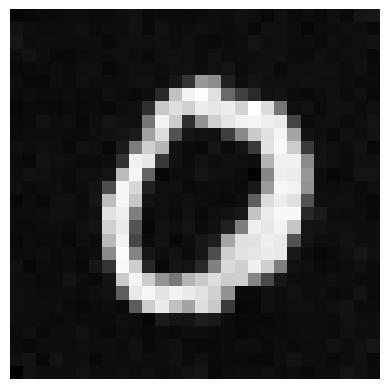

Number 'one'


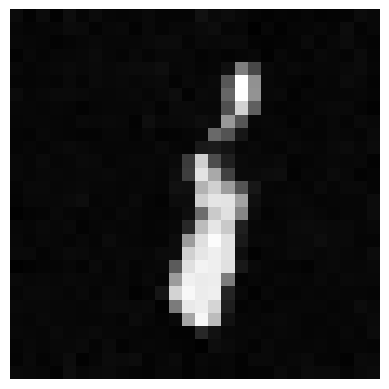

Number 'two'


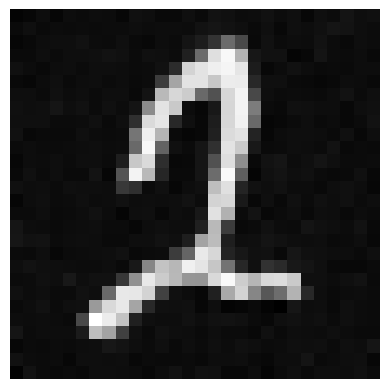

Number 'three'


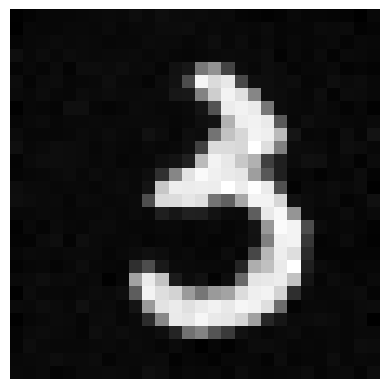

Number 'four'


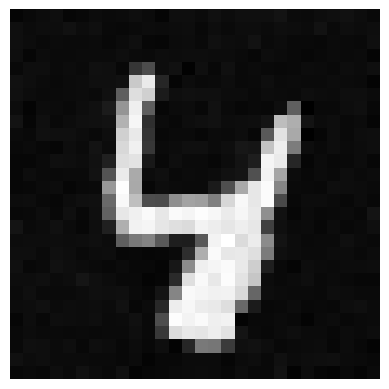

Number 'five'


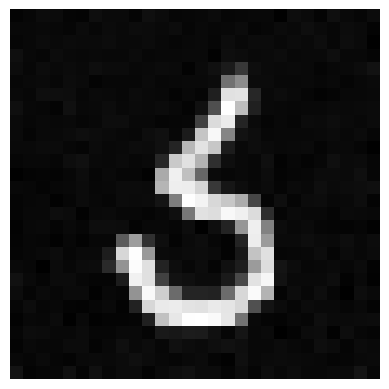

Number 'six'


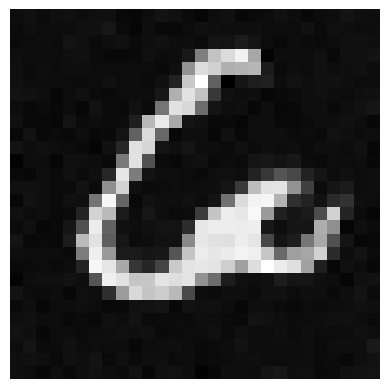

Number 'seven'


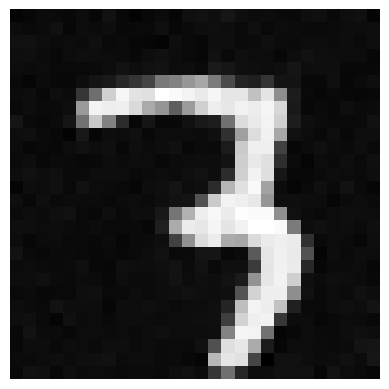

Number 'eight'


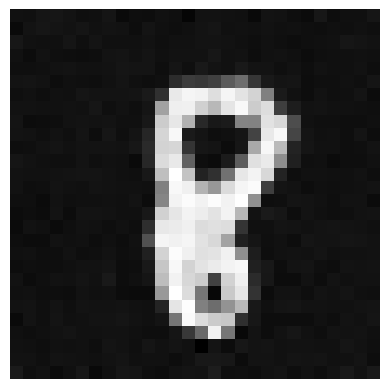

Number 'nine'


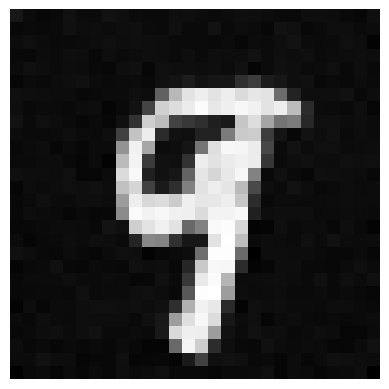

Number 'ten'


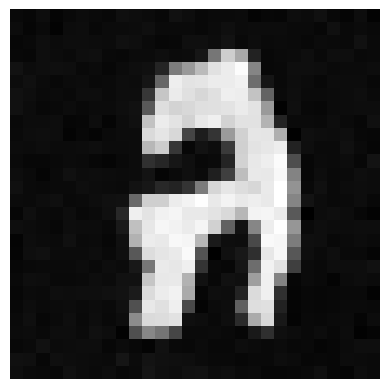

In [ ]:
# Run testing DDPM
test_numbers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
sampled_imgs = sampling_imgs(state, test_numbers, mode="ddpm")

# Visualize testing results
for idx in range(len(test_numbers)):
    print(f"Number '{n2t_mapping[test_numbers[idx]]}'")

    max_v = np.max(sampled_imgs[idx][0])
    min_v = np.min(sampled_imgs[idx][0])
    img = (sampled_imgs[idx][0] - min_v) / (max_v - min_v)
    show_img(img)

100%|██████████| 300/300 [00:42<00:00,  7.02it/s]



Number: ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten']
Step: 300


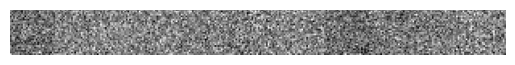

Step: 250


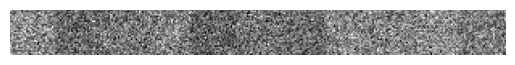

Step: 200


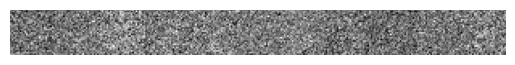

Step: 150


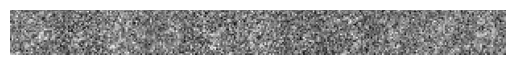

Step: 100


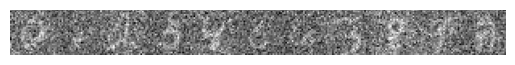

Step: 50


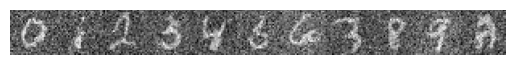

Step: 0


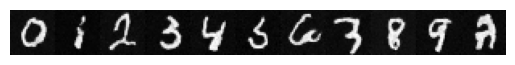

In [ ]:
test_numbers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
steps = list(range(T, -1, -50))

reverse_steps = sampling_imgs(state, test_numbers, return_steps=steps)

print("\n=========================\n")
print("Number:", [n2t_mapping[x] for x in test_numbers])

for sidx, step in enumerate(steps):
    print("Step:", step)
    step_img = []

    for idx in range(len(test_numbers)):
        max_v = np.max(reverse_steps[sidx][idx][0])
        min_v = np.min(reverse_steps[sidx][idx][0])
        img = (reverse_steps[sidx][idx][0] - min_v) / (max_v - min_v)
        step_img.append(img)

    step_img = np.concatenate(step_img, axis=-1)
    show_img(step_img)

In [ ]:
# Save to Google Drive (optional - uncomment if using Colab)
# !cp contextual_model_params.pkl "/content/drive/MyDrive/Colab Notebooks/Diffusion/contextual_model_params.pkl"
# !cp beta_t.pkl "/content/drive/MyDrive/Colab Notebooks/Diffusion/beta_t.pkl"